In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
sns.set()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, initializers

In [2]:
# Read the data
df = pd.read_csv('Put_data.csv')
df = df.drop(['Unnamed: 0', 'START_DATE', 'END_DATE'], axis = 1)
df.head()

,UNDERLYING,SKRIKE,MATURITY,DELTA,BID,ASK,IMPLIED_VOL,LIQUIDITY,INTEREST_RATE,OPTIONS_PRICE
0,324.87,270.0,0.002854,-0.00680,0.05,0.06,0.28440,2.365532e-16,1.53,-52.407802
1,324.87,275.0,0.002854,-0.00879,0.07,0.08,0.26526,2.365532e-16,1.53,-47.408012
2,324.87,280.0,0.002854,-0.01102,0.08,0.09,0.24827,2.365532e-16,1.53,-42.408222
3,324.87,285.0,0.002854,-0.01617,0.11,0.13,0.23112,1.136364e-02,1.53,-37.408433
4,324.87,299.0,0.002854,-0.04341,0.28,0.29,0.18376,1.892426e-16,1.53,-23.409021


In [3]:
X = df[df.columns.values[:-1]]
y = df['OPTIONS_PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39167, 9), (9792, 9), (39167,), (9792,))

In [4]:
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train), columns = X.columns.values) 
X_test = pd.DataFrame(scalerX.transform(X_test), columns = X.columns.values) 

scalery = MinMaxScaler().fit(y_train.values.reshape(-1, 1))
y_train = scalery.transform(y_train.values.reshape(-1, 1))
y_test = scalery.transform(y_test.values.reshape(-1, 1))

In [5]:
def plot_loss(history):
    plt.figure(figsize = (8,6))
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    
def plot_time(time):
    print('The total training time is {} seconds.'.format(np.round(np.sum(time), 1)))
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1, len(time) + 1), time)
    plt.xlabel('Epoch')
    plt.ylabel('Time for each epoch')
    plt.grid(True)
    
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.times = []

    def on_epoch_begin(self, batch, logs = {}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs = {}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
np.random.seed(123)
tf.random.set_seed(123)

learning_rate = [1e-2, 1e-3, 1e-4]
History = []
times = []
earlyStop = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

for lr in learning_rate:
    model = models.Sequential()
    # Input layer
    model.add(layers.Dense(units = 9,
                           kernel_initializer = initializers.RandomNormal(seed = 123),
                           bias_initializer = initializers.Zeros()))
    model.add(layers.Activation(activations.elu))

    numLayers = 5
    for i in range(numLayers):
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(units = 100, 
                               kernel_initializer = initializers.RandomNormal(seed = 123),
                               bias_initializer = initializers.Zeros()))
        model.add(layers.Activation(activations.elu))
        model.add(layers.Dropout(0.25))

    # Output layer
    model.add(layers.Dense(units = 1))
    model.add(layers.LeakyReLU(alpha = 1))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lr), loss = "mean_squared_error"
    )
    
    time_callback = TimeHistory()

    history = model.fit(X_train, 
        y_train, 
        epochs = 100, 
        verbose = 0,
        batch_size = 64, 
        callbacks = [earlyStop, time_callback],
        validation_split = 0.2)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print('When the learning rate is', lr)
    print("The training R squared is", 
          np.round(r2_score(y_train, train_pred), 4))
    print("The testing R squared is", 
          np.round(r2_score(y_test, test_pred), 4))
    print('-------------------------------------------------------------------')
    History.append(history)
    times.append(time_callback.times)
    path = "/Users/gaojinglun/Desktop/Research/2.5/2.5Put_LR" + str(lr) + ".h5"
    model.save(path)

When the learning rate is 0.01
The training R squared is 0.9592
The testing R squared is 0.958
-------------------------------------------------------------------
When the learning rate is 0.001
The training R squared is 0.9815
The testing R squared is 0.9812
-------------------------------------------------------------------
When the learning rate is 0.0001
The training R squared is 0.995
The testing R squared is 0.9949
-------------------------------------------------------------------


The total training time is 92.3 seconds.


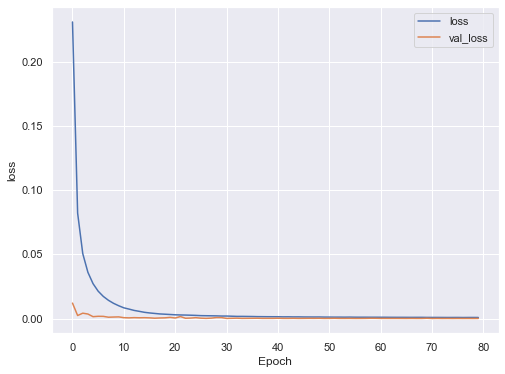

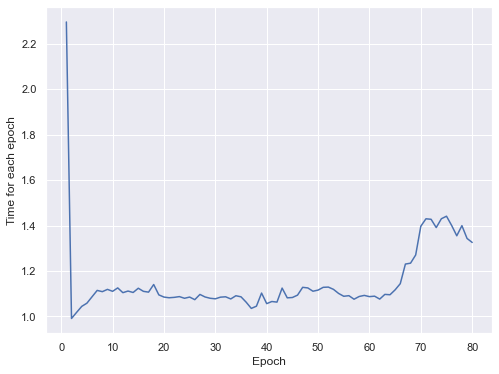

In [7]:
plot_loss(History[2])
plot_time(times[2])